<a href="https://colab.research.google.com/github/rtjord/ece570-project/blob/main/ECE_570_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Tiny Reproduction of CutMix on CIFAR-100 and Tiny ImageNet

>[A Tiny Reproduction of CutMix on CIFAR-100 and Tiny ImageNet](#scrollTo=pGH7Z0hfEAtY)

>[Overview](#scrollTo=Qqcd8t6G7fmR)

>>[What you’ll do](#scrollTo=Qqcd8t6G7fmR)

>>[Outputs & visuals](#scrollTo=Qqcd8t6G7fmR)

>>[Run order (per dataset)](#scrollTo=Qqcd8t6G7fmR)

>[Runtime Setup](#scrollTo=Fl4iaIoSETEz)

>>[Set Up File Directory](#scrollTo=4zb6uHYTGawp)

>>[Set Seed](#scrollTo=4URjJlVfGmKh)

>>[Print Device Info and Package Versions](#scrollTo=zV1SAaGiG1Xk)

>[Helpers](#scrollTo=IEoTzlq7wBZn)

>>[Get Device](#scrollTo=Z2yIwlSWHrRN)

>[Load Data](#scrollTo=5dzCEj2jusP6)

>>[Make Augmentations](#scrollTo=MFQblUZxrvtO)

>>[Make Transforms](#scrollTo=wlwgTPZLIVDf)

>>[CIFAR-100 Data Loaders](#scrollTo=DPX6N4KUJIux)

>>[Download Tiny ImageNet](#scrollTo=-9t303LUJwBC)

>>[Construct Tiny ImageNet Validation](#scrollTo=wbRB1FwlKQfD)

>>[Tiny ImageNet Data Loaders](#scrollTo=WZTDt77PKdEW)

>[Build Model](#scrollTo=w6WhObE6vh5B)

>[Train Model](#scrollTo=6GdW2IhbvtSt)

>>[Soft Categorical Cross-Entropy](#scrollTo=06Y2AhjzO98A)

>>[Plotting Helper](#scrollTo=ub-tpV1hPVU2)

>>[Train One Epoch](#scrollTo=LfO7wYCjOW4e)

>>[Training Loop](#scrollTo=jRmkAvixWdmc)

>[Evaluate Model](#scrollTo=m2jQXMHEvvjc)

>[Run Experiment (Train + Test)](#scrollTo=RUA1Ycgj1hS5)

>[Global Config](#scrollTo=egwwakGrE2Dk)

>[ResNet-50 CIFAR-100](#scrollTo=119xYLjkFQhC)

>>[Baseline](#scrollTo=053-lvam1kUF)

>>[CutMix](#scrollTo=Ft9_i0T49uRm)

>[ResNet-18 CIFAR-100](#scrollTo=FZjvvYroFpBh)

>>[Baseline](#scrollTo=Ddt8Gj7k8Plf)

>>[CutMix](#scrollTo=rmH6Wp23Ca1Z)

>>[Cutout](#scrollTo=e9Y80pGNkehE)

>>[MixUp](#scrollTo=_oGl1HoIkiFq)

>[Comparison](#scrollTo=dC2pUTymlNXU)

>[Create Figures](#scrollTo=gH90e69ybkUF)

>>[Data Augmentation Examples](#scrollTo=TgIT35UtnnWl)

>>[Training History](#scrollTo=uVnbU2CCnsZW)



# Overview

**Goal:** Trains and evaluate a single ResNet-18 on two datasets with shared code, clear stats, and useful visuals.

## What you’ll do
- **Load & explore data (no transforms):** dataset sizes, class names, quick image grids.
- **Show base transforms:** preview train/eval pipelines (resize/crop/normalize).
- **Visualize MixUp & CutMix:** see how each augmentation alters a batch.
- **Build the model:** load ImageNet-pretrained ResNet-18; swap the head to match classes (100 for CIFAR-100, 200 for Tiny ImageNet).
- **Train in two phases per dataset:**
  1) **Linear probe** (train head only) → log loss, Top-1/Top-5, time; plot curves  
  2) **Full fine-tune** (unfreeze all) → log/plot metrics again
- **Test & analyze:** final test loss/Top-1/Top-5, confusion matrix, a few example predictions.
- **Compare results:** compact table (CIFAR-100 vs Tiny ImageNet) and a small bar chart.

## Outputs & visuals
- Dataset stats (sizes, per-class counts, channel means/stds)
- Image grids (raw + transformed)
- MixUp & CutMix montages
- Training curves (loss, Top-1)
- Final confusion matrix per dataset
- Summary table across datasets

## Run order (per dataset)
1. **Data loading → stats → raw visuals**  
2. **Transform previews (train/eval)**  
3. **MixUp/CutMix visualization**  
4. **Model build (pretrained) + head swap**  
5. **Linear probe training + metrics/plots**  
6. **Full fine-tune + metrics/plots**  
7. **Test evaluation + confusion matrix + examples**

> **Tip:** Use a **GPU runtime** in Colab (`Runtime → Change runtime type → GPU`) for reasonable training speed.


# Runtime Setup

## Set Up File Directory

In [56]:
import os, random, platform
from pathlib import Path
import numpy as np
import torch
import torchvision
import matplotlib

# ---- Base paths ----
BASE_DIR = Path("./")
DATA_DIR = BASE_DIR / "data"
CKPT_DIR = BASE_DIR / "checkpoints"
RESULTS_DIR = BASE_DIR / "results"
FIG_DIR = BASE_DIR / "figures"
for d in [DATA_DIR, CKPT_DIR, RESULTS_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)


## Set Seed



In [2]:
import random
import numpy as np
import torch


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

## Print Device Info and Package Versions

In [3]:
import torch
import torchvision
import matplotlib
import platform

# ---- Device info ----
if torch.cuda.is_available():
    device = torch.device("cuda")
    props = torch.cuda.get_device_properties(0)
    cc = f"{props.major}.{props.minor}"
    print(f"Device: CUDA — {torch.cuda.get_device_name(0)} (cc {cc})")
    print(f"GPU RAM: {props.total_memory/1e9:.2f} GB")
else:
    device = torch.device("cpu")
    print("Device: CPU")

# ---- Versions ----
print(f"PyTorch:     {torch.__version__} (CUDA {torch.version.cuda})")
print(f"Torchvision: {torchvision.__version__}")
print(f"Matplotlib:  {matplotlib.__version__}")
print(f"Python:      {platform.python_version()}")

# ---- Paths summary ----
print(f"DATA_DIR = {DATA_DIR}")
print(f"CKPT_DIR = {CKPT_DIR}")
print(f"FIG_DIR  = {FIG_DIR}")

Device: CUDA — NVIDIA A100-SXM4-80GB (cc 8.0)
GPU RAM: 85.17 GB
PyTorch:     2.8.0+cu126 (CUDA 12.6)
Torchvision: 0.23.0+cu126
Matplotlib:  3.10.0
Python:      3.12.12
DATA_DIR = data
CKPT_DIR = checkpoints
FIG_DIR  = figs


# Helpers

## Get Device

In [4]:
import torch

def get_device():
    """Prefer CUDA, then Apple MPS, else CPU."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

# Load Data

## Make Augmentations

In [5]:
from torch import nn
from torchvision.transforms import v2 as T2


def make_batch_aug(num_classes: int, mode: str = "none", p: float = 0.5):
    """
    Construct a batch-level augmentation module (MixUp, CutMix, Cutout)
    or return None if mode is 'none'/'off'.
    """
    m = (mode or "none").lower()
    if m in ("none", "off"):
        return None

    if m == "mixup":
        return T2.RandomApply(
            nn.ModuleList([T2.MixUp(num_classes=num_classes, alpha=1.0)]),
            p=p,
        )

    if m == "cutmix":
        return T2.RandomApply(
            nn.ModuleList([T2.CutMix(num_classes=num_classes, alpha=1.0)]),
            p=p,
        )

    if m == "cutout":
        # Use RandomErasing to mimic Cutout-style behavior
        return T2.RandomErasing(
            p=p,                 # apply with probability p
            scale=(0.25, 0.25),  # fixed area ~25% of the image
            ratio=(1.0, 1.0),
            value=0.0,
            inplace=True,
        )

    raise ValueError("mix mode must be one of: 'none', 'mixup', 'cutmix', 'cutout'")

## Make Transforms

In [6]:
from torchvision import transforms, models

CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def make_cifar_transforms(train: bool = True, architecture="resnet18"):
    if train:
        return transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
        ])
    else:
        return transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
        ])

def make_imagenet_transforms(train: bool = True, architecture="resnet18"):
    if train:
        return transforms.Compose([
            transforms.RandomResizedCrop(64),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])
    else:
        weights = models.ResNet50_Weights.IMAGENET1K_V1
        return weights.transforms()

## CIFAR-100 Data Loaders

In [7]:
from pathlib import Path
import torch
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import datasets
from typing import Tuple, List


def build_cifar100_loaders(
    architecture: str,
    batch_size: int,
    num_workers: int,
    seed: int,
    root: str | Path = "./data",
) -> Tuple[DataLoader, DataLoader, DataLoader, List[str]]:

    root = Path(root)
    pin  = torch.cuda.is_available()

    # Per-sample transforms
    tf_train = make_cifar_transforms(train=True, architecture=architecture)   # augments + ImageNet norm
    tf_eval  = make_cifar_transforms(train=False, architecture=architecture)  # built-in eval transform

    # Two logically identical train datasets, differing only by transform
    train_ds_aug  = datasets.CIFAR100(root=str(root), train=True,  download=True,  transform=tf_train)
    train_ds_eval = datasets.CIFAR100(root=str(root), train=True,  download=False, transform=tf_eval)
    test_ds       = datasets.CIFAR100(root=str(root), train=False, download=True,  transform=tf_eval)

    class_names = list(train_ds_aug.classes)

    # Deterministic split on indices (shared across both train datasets)
    n_total = len(train_ds_aug)
    n_val   = int(round(n_total * 0.1))
    n_train = n_total - n_val

    # random_split returns Subset objects; we only need their indices
    g = torch.Generator().manual_seed(seed)  # isolate the randomness of the split
    train_subset_idx, val_subset_idx = random_split(range(n_total), [n_train, n_val], generator=g)
    train_idx = list(train_subset_idx.indices)
    val_idx   = list(val_subset_idx.indices)

    # Subset with appropriate transforms
    train_subset = Subset(train_ds_aug,  train_idx)  # aug pipeline
    val_subset   = Subset(train_ds_eval, val_idx)    # eval pipeline (SAME as test)

    # DataLoaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin
    )
    test_loader  = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin
    )

    return train_loader, val_loader, test_loader, class_names

## Download Tiny ImageNet

In [5]:
from pathlib import Path
import subprocess

def ensure_tinyimagenet(root: str | Path = "./data") -> Path:
    """
    Ensure Tiny ImageNet is present under root.
    Downloads and unzips into root/tiny-imagenet-200 if missing.
    """
    root = Path(root)
    target_dir = root / "tiny-imagenet-200"
    zip_path = root / "tiny-imagenet-200.zip"

    if not target_dir.exists():
        root.mkdir(parents=True, exist_ok=True)

        # Download if zip not already there
        if not zip_path.exists():
            print("Downloading Tiny ImageNet...")
            subprocess.run(
                ["wget", "http://cs231n.stanford.edu/tiny-imagenet-200.zip", "-O", str(zip_path)],
                check=True
            )

        # Unzip into root
        print("Unzipping Tiny ImageNet...")
        print(zip_path)
        subprocess.run(["unzip", str(zip_path), "-d", str(root)], check=True)

    return target_dir

## Construct Tiny ImageNet Validation

In [9]:
from pathlib import Path
import os
import subprocess
from typing import Optional
import torch
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import transforms, models
from PIL import Image


# --- Tiny ImageNet helpers ---

class TinyImageNetVal(Dataset):
    """
    Tiny-ImageNet 'val' folder uses a CSV-style annotation file instead of class subfolders.
    This dataset reads 'val_annotations.txt' and maps each image to the corresponding wnid.
    Expects the standard layout:
      root/
        train/<wnid>/*.JPEG
        val/images/*.JPEG
        val/val_annotations.txt  (filename, wnid, x, y, w, h ...)
        wnids.txt (optional)
    """
    def __init__(self, root: str | Path, transform=None, class_to_idx: Optional[dict] = None):
        self.root = Path(root)
        self.transform = transform
        anno_path = self.root / "val" / "val_annotations.txt"
        images_dir = self.root / "val" / "images"

        # Build class_to_idx from train if not given
        if class_to_idx is None:
            train_dir = self.root / "train"
            wnids = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
            class_to_idx = {wnid: i for i, wnid in enumerate(wnids)}
        self.class_to_idx = class_to_idx

        # Parse annotations
        self.samples = []  # list of (image_path, target_idx)
        with open(anno_path, "r") as f:
            for line in f:
                parts = line.strip().split("\t")
                if len(parts) < 2:
                    parts = line.strip().split()  # fallback on whitespace
                fname, wnid = parts[0], parts[1]
                if wnid not in self.class_to_idx:
                    # If class not in mapping (shouldn't happen), skip
                    continue
                img_path = images_dir / fname
                self.samples.append((img_path, self.class_to_idx[wnid]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, target

## Tiny ImageNet Data Loaders

In [10]:
from pathlib import Path
from torch.utils.data import DataLoader, random_split
from typing import Tuple, List
import torch
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets


def build_tinyimagenet_loaders(
    architecture: str,
    batch_size: int,
    num_workers: int,
    seed: int,
    root: str | Path = "./data",
) -> Tuple[DataLoader, DataLoader, DataLoader, List[str]]:
    """
    Returns train_loader, val_loader, test_loader, class_names for Tiny ImageNet.
    - train: ImageFolder(root/train)
    - val: uses TinyImageNetVal (annotation file) OR ImageFolder if already reorganized
    - test: labels are not provided in the official release; we reuse 'val' as 'test' for metrics.
    """
    root = Path(root)
    ensure_tinyimagenet(root)
    pin = torch.cuda.is_available()

    tf_train = make_imagenet_transforms(train=True, architecture=architecture)
    tf_eval  = make_imagenet_transforms(train=False, architecture=architecture)

    train_dir = root / "tiny-imagenet-200" / "train"

    # Two logically identical train datasets, differing only by transform
    train_ds_aug  = datasets.ImageFolder(str(train_dir), transform=tf_train)
    train_ds_eval = datasets.ImageFolder(str(train_dir), transform=tf_eval)
    assert len(train_ds_aug.classes) == 200, f"Expected 200 train classes, got {len(train_ds_aug.classes)}"
    class_names = list(train_ds_aug.classes)  # wnids

    # Deterministic split on indices (shared across both train datasets)
    n_total = len(train_ds_aug)
    n_val   = int(round(n_total * 0.1))
    n_train = n_total - n_val

    # random_split returns Subset objects; we only need their indices
    g = torch.Generator().manual_seed(seed)  # isolate the randomness of the split
    train_subset_idx, val_subset_idx = random_split(range(n_total), [n_train, n_val], generator=g)
    train_idx = list(train_subset_idx.indices)
    val_idx   = list(val_subset_idx.indices)

    # Subset with appropriate transforms
    train_subset = Subset(train_ds_aug,  train_idx)  # aug pipeline
    val_subset   = Subset(train_ds_eval, val_idx)    # eval pipeline (SAME as test)

    # Use validation set as test set
    test_set = TinyImageNetVal(
        root / "tiny-imagenet-200",
        transform=tf_eval,
        class_to_idx=train_ds_aug.class_to_idx
    )

    # DataLoaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin,
        persistent_workers=(num_workers > 0),
        prefetch_factor=2 if num_workers > 0 else None,
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin,
        persistent_workers=(num_workers > 0),
        prefetch_factor=2 if num_workers > 0 else None,
    )
    test_loader  = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin,
        persistent_workers=(num_workers > 0),
        prefetch_factor=2 if num_workers > 0 else None,
    )

    return train_loader, val_loader, test_loader, class_names

# Build Model

In [22]:
import torchvision
from torch import nn

import torchvision
from torch import nn

def build_cifar100_model(architecture: str):
    """
    CIFAR-style ResNet stem: 3x3 conv, stride 1, no maxpool.
    Good for 32x32 inputs when training from scratch.
    """
    if architecture == "resnet18":
        model = torchvision.models.resnet18(weights=None)
    elif architecture == "resnet50":
        model = torchvision.models.resnet50(weights=None)
    else:
        raise ValueError(f"Unknown architecture {architecture}")

    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False
    )
    model.maxpool = nn.Identity()

    model.fc = nn.Linear(model.fc.in_features, 100)
    return model


def build_tiny_imagenet_model(architecture: str):
    """
    Original ResNet model with fully connected layer swapped for
    correct number of classes
    """
    if architecture == "resnet18":
        model = torchvision.models.resnet18(weights=None)
    elif architecture == "resnet50":
        model = torchvision.models.resnet50(weights=None)
    else:
        raise ValueError(f"Unknown architecture {architecture}")

    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False
    )
    # model.maxpool = nn.Identity()

    model.fc = nn.Linear(model.fc.in_features, 200)
    return model

# Train Model

## Soft Categorical Cross-Entropy

In [12]:
from torch import nn

class SoftCE(nn.Module):
    def forward(self, logits, targets):
        if targets.dtype in (torch.long, torch.int64):  # hard labels
            return nn.functional.cross_entropy(logits, targets)
        logp = nn.functional.log_softmax(logits, dim=-1)
        return -(targets * logp).sum(dim=-1).mean()

## Plotting Helper

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_curves(history: dict, title: str):
    """Plot train loss and val top-1 from a History dict."""
    if not history or "train_loss" not in history:
        print("Nothing to plot.")
        return
    xs = np.arange(1, len(history["train_loss"]) + 1)
    fig, ax1 = plt.subplots()
    ax1.plot(xs, history["train_loss"], label="train_loss")
    ax1.plot(xs, history.get("val_loss", []), label="val_loss")
    ax1.set_xlabel("epoch"); ax1.set_ylabel("loss"); ax1.grid(True, alpha=0.3)
    ax2 = ax1.twinx()
    if "val_top1" in history:
        ax2.plot(xs, history["val_top1"], "o--", label="val_top1", alpha=0.7)
        ax2.set_ylabel("Top-1 (%)")
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="best")
    plt.title(title)
    plt.savefig(FIG_DIR / f"{title}.png")
    plt.show()

## Train One Epoch

In [14]:
import torch
from torch import nn


def train_one_epoch(
    model,
    loader,
    optimizer,
    *,
    device=None,
    batch_aug=None,
    amp=True,
):
    """One training epoch. Returns average loss."""
    device = device or get_device()
    model.train()
    criterion = SoftCE()

    scaler = torch.amp.GradScaler(
        device="cuda",
        enabled=(amp and device.type == "cuda")
    )
    running_loss, seen = 0.0, 0

    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        if batch_aug is not None:
            x, y = batch_aug(x, y)  # may return soft targets

        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type=device.type, enabled=(amp and device.type in {"cuda", "mps"})):
            logits = model(x)
            loss = criterion(logits, y)

        if scaler.is_enabled():
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        bs = y.size(0)
        running_loss += loss.item() * bs
        seen += bs

    return running_loss / max(1, seen)

## Training Loop

In [15]:
import numpy as np
import copy

def cpu_state_dict(model):
    return {k: v.detach().cpu() for k, v in model.state_dict().items()}

def train(
    model,
    train_loader,
    val_loader,
    *,
    device,
    epochs,
    batch_aug=None,
    optimizer=None,
    scheduler=None,
    amp=True,
    save_path=None
):
    model.to(device)

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_top1": [],
        "val_top5": [],
        "lr": []
    }

    best_val_loss = np.inf
    best_model_checkpoint = None

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(
            model,
            train_loader,
            optimizer,
            device=device,
            batch_aug=batch_aug,
            amp=amp
        )

        val_metrics = evaluate(model, val_loader, device=device)
        val_loss = val_metrics["loss"]
        top1 = val_metrics["top1"]
        top5 = val_metrics["top5"]

        if scheduler is not None:
          # get the learning rate before stepping the scheduler
          lr = scheduler.get_last_lr()[0]
          scheduler.step()
        else:
          lr = optimizer.param_groups[0]["lr"]

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_top1"].append(top1)
        history["val_top5"].append(top5)
        history["lr"].append(lr)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_checkpoint = {
                  "epoch": epoch,
                  "model_state": cpu_state_dict(model),
            }


        print(
            f"epoch {epoch:03d} "
            f"train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  "
            f"top1={top1:.2f}%  top5={top5:.2f}%  "
            f"lr={lr}"
        )

    # Save at the end once the entire training history has finished
    if best_model_checkpoint is not None:
      best_model_checkpoint["history"] = history
      if save_path is not None:
          torch.save(best_model_checkpoint, save_path)

    return best_model_checkpoint


# Evaluate Model

In [16]:
def evaluate(model, loader, device=None, criterion=None, max_batches=None):
    """Eval with hard labels (no batch-level aug). Returns dict: loss/top1/top5."""
    device = device or get_device()
    model.eval()
    criterion = criterion or nn.CrossEntropyLoss()

    total, loss_sum, top1_sum, top5_sum = 0, 0.0, 0.0, 0.0
    with torch.no_grad():
        for b, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss_sum += criterion(logits, y).item() * y.size(0)
            total += y.size(0)

            # Top-1 / Top-5
            pred1 = logits.argmax(dim=1)
            top1_sum += (pred1 == y).sum().item()
            k = min(5, logits.size(1))
            pred5 = logits.topk(k, dim=1).indices
            top5_sum += (pred5 == y.view(-1, 1)).any(dim=1).sum().item()

            # Limit number of batches used for evaluation
            if max_batches is not None and (b + 1) >= max_batches:
                break

    return {
        "loss": loss_sum / max(1, total),
        "top1": 100.0 * top1_sum / max(1, total),
        "top5": 100.0 * top5_sum / max(1, total),
    }

# Run Experiment (Train + Test)

In [17]:
import time
import torch
from torch import nn
import numpy as np
from torchvision.transforms import v2 as T2
from google.colab import files

def run_experiment(name: str, cfg: dict):
    """
    Returns:
      {
        'name': ...,
        'history': {...},
        'test_metrics': {'loss': ..., 'top1': ..., 'top5': ...},
      }
    """
    set_seed(cfg["seed"])
    device = get_device()

    # build data loaders
    if cfg["dataset"] == "cifar100":
        train_loader, val_loader, test_loader, class_names = build_cifar100_loaders(
            architecture=cfg["architecture"],
            batch_size=cfg["batch_size"],
            num_workers=cfg["num_workers"],
            seed=cfg["seed"],
        )
        model = build_cifar100_model(
            architecture=cfg["architecture"],
        ).to(device)
        num_classes = 100
    elif cfg["dataset"] == "tinyimagenet":
        train_loader, val_loader, test_loader, class_names = build_tinyimagenet_loaders(
            architecture=cfg["architecture"],
            batch_size=cfg["batch_size"],
            num_workers=cfg["num_workers"],
            seed=cfg["seed"],
        )
        model = build_tiny_imagenet_model(
            architecture=cfg["architecture"],
        ).to(device)
        num_classes = 200
    else:
        raise Exception(f"Unknown dataset {cfg["dataset"]}")

    print("\n--- Dataset split ---")
    sizes = {
        "train": len(train_loader.dataset),
        "val":   len(val_loader.dataset),
        "test":  len(test_loader.dataset),
    }
    print(sizes)

    # These settings are the same whether fine tuning or training from scratch
    batch_aug = make_batch_aug(num_classes, cfg["aug_mode"], p=cfg["aug_prob"])

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params,
        lr=cfg["lr"],
        momentum=0.9,
        nesterov=True,
        weight_decay=cfg["weight_decay"],
    )

    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[int(0.25*cfg["epochs"]),
                    int(0.50*cfg["epochs"]),
                    int(0.75*cfg["epochs"])],
        gamma=0.1
    )

    print("\n--- Train ---")
    best_model_checkpoint = train(
        model,
        train_loader,
        val_loader,
        device=device,
        epochs=cfg["epochs"],
        batch_aug=batch_aug,
        optimizer=optimizer,
        scheduler=scheduler,
        amp=cfg["amp"],
        save_path=CKPT_DIR / f"{name}.pt"
    )
    hist = best_model_checkpoint["history"]
    plot_curves(hist, title=name)


    print("\n--- Test ---")
    # Load weights from the epoch with lowest validation loss
    model.load_state_dict(best_model_checkpoint["model_state"])

    test_metrics = evaluate(model, test_loader, device=device)
    print(
        f"loss={test_metrics['loss']:.4f}  "
        f"top1={test_metrics['top1']:.2f}%  "
        f"top5={test_metrics['top5']:.2f}%"
    )

    results = best_model_checkpoint | {
        "name": name,
        "test_metrics": test_metrics,
    }

    torch.save(results, RESULTS_DIR / f"{name}.pt")
    files.download(RESULTS_DIR / f"{name}.pt")
    return results


# Global Config
Keep these hyperparameters the same between experiments.

In [18]:
GLOBAL_CONFIG = {
    "seed": 42,
    "batch_size": 256,
    "num_workers": 4,
    "aug_prob": 0.5,
    "lr": 0.1,
    "weight_decay": 5e-4,
    "amp": True,
}

# ResNet-50 CIFAR-100

## Baseline

In [ ]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": None,
    "architecture": "resnet50",
    "epochs": 300,
}

resnet50_cifar_baseline = run_experiment("resnet50_cifar_baseline", CONFIG)

100%|██████████| 169M/169M [00:13<00:00, 12.7MB/s]



--- Dataset split ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Train ---
epoch 001 train_loss=5.0163  val_loss=4.5634  top1=1.82%  top5=7.42%  lr=0.1
epoch 002 train_loss=4.5474  val_loss=4.5074  top1=2.30%  top5=9.42%  lr=0.1
epoch 003 train_loss=4.3736  val_loss=4.1507  top1=4.40%  top5=20.48%  lr=0.1
epoch 004 train_loss=3.9904  val_loss=3.8901  top1=8.32%  top5=29.20%  lr=0.1
epoch 005 train_loss=3.7230  val_loss=3.5871  top1=12.46%  top5=38.68%  lr=0.1
epoch 006 train_loss=3.4652  val_loss=3.3237  top1=18.04%  top5=47.26%  lr=0.1
epoch 007 train_loss=3.1792  val_loss=3.2306  top1=20.92%  top5=50.22%  lr=0.1
epoch 008 train_loss=2.9107  val_loss=2.8951  top1=27.14%  top5=57.30%  lr=0.1
epoch 009 train_loss=2.6204  val_loss=2.6684  top1=31.94%  top5=63.00%  lr=0.1
epoch 010 train_loss=2.3611  val_loss=2.5436  top1=34.48%  top5=66.60%  lr=0.1
epoch 011 train_loss=2.1434  val_loss=2.4197  top1=36.98%  top5=69.32%  lr=0.1
epoch 012 train_loss=1.9667  val_loss=2.1607  top1=42.

Exception in thread Thread-44 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 61, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 37, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/resource_

KeyboardInterrupt: 

## CutMix


--- Dataset split ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Train ---
epoch 001 train_loss=4.9879  val_loss=4.6048  top1=0.88%  top5=5.32%  lr=0.1
epoch 002 train_loss=4.5959  val_loss=4.5748  top1=1.60%  top5=8.52%  lr=0.1
epoch 003 train_loss=4.5517  val_loss=4.4331  top1=2.24%  top5=11.08%  lr=0.1
epoch 004 train_loss=4.3531  val_loss=4.1420  top1=5.56%  top5=20.90%  lr=0.1
epoch 005 train_loss=4.1614  val_loss=3.8778  top1=8.62%  top5=29.54%  lr=0.1
epoch 006 train_loss=3.9899  val_loss=3.6481  top1=11.92%  top5=36.92%  lr=0.1
epoch 007 train_loss=3.8323  val_loss=3.5219  top1=15.68%  top5=41.46%  lr=0.1
epoch 008 train_loss=3.6992  val_loss=3.2631  top1=20.04%  top5=48.90%  lr=0.1
epoch 009 train_loss=3.5087  val_loss=3.0554  top1=23.18%  top5=54.82%  lr=0.1
epoch 010 train_loss=3.3492  val_loss=2.7517  top1=29.34%  top5=61.78%  lr=0.1
epoch 011 train_loss=3.0868  val_loss=2.6991  top1=32.02%  top5=62.74%  lr=0.1
epoch 012 train_loss=2.9612  val_loss=2.6225  top1=33.4

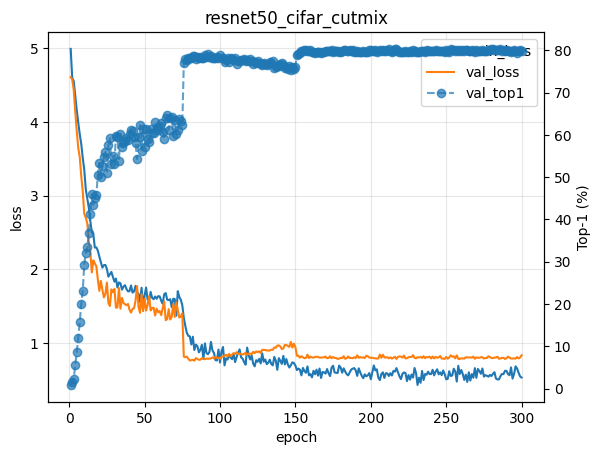


--- Test ---
loss=0.8224  top1=80.75%  top5=95.37%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": "cutmix",
    "architecture": "resnet50",
    "epochs": 300,
}

resnet50_cifar_cutmix = run_experiment("resnet50_cifar_cutmix", CONFIG)

## Cutout


--- Dataset split ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Train ---
epoch 001 train_loss=5.0036  val_loss=4.5720  top1=1.40%  top5=7.50%  lr=0.1
epoch 002 train_loss=4.5029  val_loss=4.4590  top1=1.82%  top5=10.18%  lr=0.1
epoch 003 train_loss=4.3537  val_loss=4.1853  top1=3.84%  top5=19.04%  lr=0.1
epoch 004 train_loss=4.1012  val_loss=3.9682  top1=7.10%  top5=25.92%  lr=0.1
epoch 005 train_loss=3.9362  val_loss=3.8457  top1=9.00%  top5=30.56%  lr=0.1
epoch 006 train_loss=3.7811  val_loss=3.6271  top1=13.38%  top5=37.28%  lr=0.1
epoch 007 train_loss=3.6555  val_loss=3.5064  top1=15.38%  top5=40.36%  lr=0.1
epoch 008 train_loss=3.4969  val_loss=3.4132  top1=17.24%  top5=44.38%  lr=0.1
epoch 009 train_loss=3.3275  val_loss=3.1521  top1=21.60%  top5=51.84%  lr=0.1
epoch 010 train_loss=3.1615  val_loss=3.0091  top1=25.10%  top5=55.44%  lr=0.1
epoch 011 train_loss=2.9643  val_loss=2.7353  top1=29.06%  top5=61.90%  lr=0.1
epoch 012 train_loss=2.7804  val_loss=2.6640  top1=32.

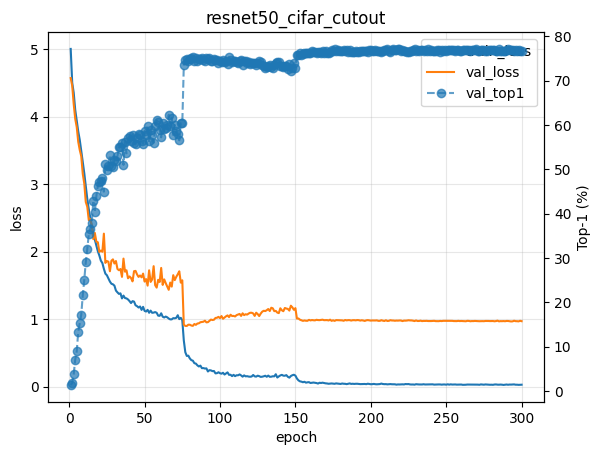


--- Test ---
loss=0.9895  top1=76.03%  top5=93.72%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": "cutout",
    "architecture": "resnet50",
    "epochs": 300,
}

resnet50_cifar_cutout = run_experiment("resnet50_cifar_cutout", CONFIG)

## Mixup


--- Dataset split ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Train ---
epoch 001 train_loss=4.9480  val_loss=4.5494  top1=1.64%  top5=7.72%  lr=0.1
epoch 002 train_loss=4.5153  val_loss=4.4356  top1=2.22%  top5=11.66%  lr=0.1
epoch 003 train_loss=4.3410  val_loss=4.0935  top1=5.60%  top5=22.10%  lr=0.1
epoch 004 train_loss=4.1429  val_loss=3.9121  top1=8.78%  top5=28.70%  lr=0.1
epoch 005 train_loss=3.9758  val_loss=3.6493  top1=13.16%  top5=37.54%  lr=0.1
epoch 006 train_loss=3.8202  val_loss=3.4630  top1=16.56%  top5=43.88%  lr=0.1
epoch 007 train_loss=3.6749  val_loss=3.3241  top1=18.92%  top5=47.30%  lr=0.1
epoch 008 train_loss=3.4754  val_loss=3.0935  top1=23.72%  top5=53.12%  lr=0.1
epoch 009 train_loss=3.3355  val_loss=2.8292  top1=28.52%  top5=59.56%  lr=0.1
epoch 010 train_loss=3.1564  val_loss=2.7277  top1=31.50%  top5=62.12%  lr=0.1
epoch 011 train_loss=2.9905  val_loss=2.6083  top1=33.42%  top5=66.12%  lr=0.1
epoch 012 train_loss=2.9127  val_loss=2.3299  top1=38

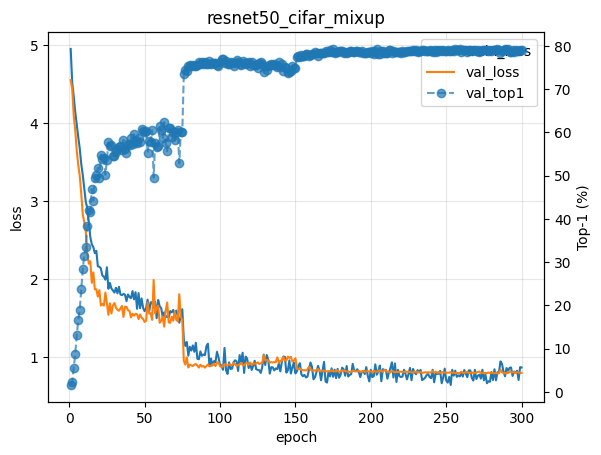


--- Test ---
loss=0.8244  top1=78.41%  top5=94.49%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": "mixup",
    "architecture": "resnet50",
    "epochs": 300,
}

resnet50_cifar_mixup = run_experiment("resnet50_cifar_mixup", CONFIG)

# ResNet-18 CIFAR-100

## Baseline


--- Dataset split ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Train ---
epoch 001 train_loss=3.7067  val_loss=3.3702  top1=18.86%  top5=47.44%  lr=0.1
epoch 002 train_loss=2.8538  val_loss=2.6869  top1=32.50%  top5=63.76%  lr=0.1
epoch 003 train_loss=2.3312  val_loss=2.4363  top1=37.22%  top5=68.96%  lr=0.1
epoch 004 train_loss=1.9912  val_loss=2.1399  top1=42.72%  top5=75.18%  lr=0.1
epoch 005 train_loss=1.7520  val_loss=1.9305  top1=48.42%  top5=79.50%  lr=0.1
epoch 006 train_loss=1.5835  val_loss=2.2416  top1=42.78%  top5=74.92%  lr=0.1
epoch 007 train_loss=1.4499  val_loss=1.8853  top1=48.46%  top5=80.44%  lr=0.1
epoch 008 train_loss=1.3450  val_loss=1.7188  top1=52.24%  top5=83.40%  lr=0.1
epoch 009 train_loss=1.2528  val_loss=1.5730  top1=56.80%  top5=85.20%  lr=0.1
epoch 010 train_loss=1.1750  val_loss=1.5975  top1=55.08%  top5=85.16%  lr=0.1
epoch 011 train_loss=1.1171  val_loss=1.5065  top1=58.18%  top5=86.76%  lr=0.1
epoch 012 train_loss=1.0559  val_loss=1.6378  to

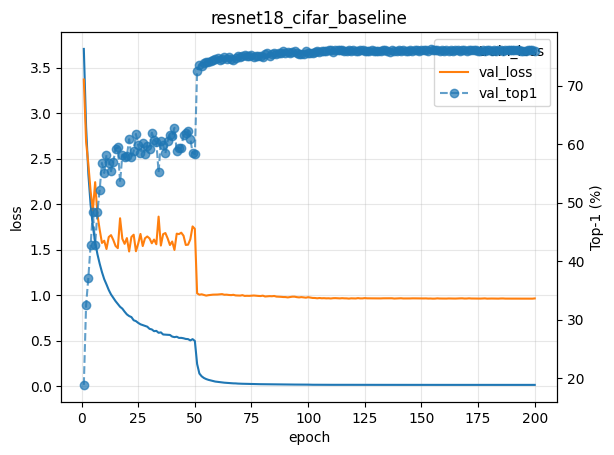


--- Test ---
loss=0.9756  top1=75.67%  top5=93.22%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": None,
    "architecture": "resnet18",
    "epochs": 200,
}

resnet18_cifar_baseline = run_experiment("resnet18_cifar_baseline", CONFIG)

## CutMix


--- Dataset split ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Train ---
epoch 001 train_loss=4.0297  val_loss=3.5282  top1=16.78%  top5=43.46%  lr=0.1
epoch 002 train_loss=3.5212  val_loss=3.0380  top1=24.50%  top5=54.46%  lr=0.1
epoch 003 train_loss=3.1245  val_loss=2.8766  top1=28.56%  top5=58.14%  lr=0.1
epoch 004 train_loss=2.8989  val_loss=2.4067  top1=37.14%  top5=69.38%  lr=0.1
epoch 005 train_loss=2.6447  val_loss=2.3002  top1=39.66%  top5=71.16%  lr=0.1
epoch 006 train_loss=2.4485  val_loss=2.0161  top1=45.96%  top5=77.04%  lr=0.1
epoch 007 train_loss=2.3714  val_loss=2.1285  top1=43.16%  top5=76.16%  lr=0.1
epoch 008 train_loss=2.3787  val_loss=1.8680  top1=49.78%  top5=80.08%  lr=0.1
epoch 009 train_loss=2.3190  val_loss=1.7537  top1=51.78%  top5=81.84%  lr=0.1
epoch 010 train_loss=2.1925  val_loss=1.8629  top1=49.54%  top5=79.92%  lr=0.1
epoch 011 train_loss=2.1064  val_loss=1.8266  top1=51.10%  top5=81.12%  lr=0.1
epoch 012 train_loss=1.9016  val_loss=1.8636  to

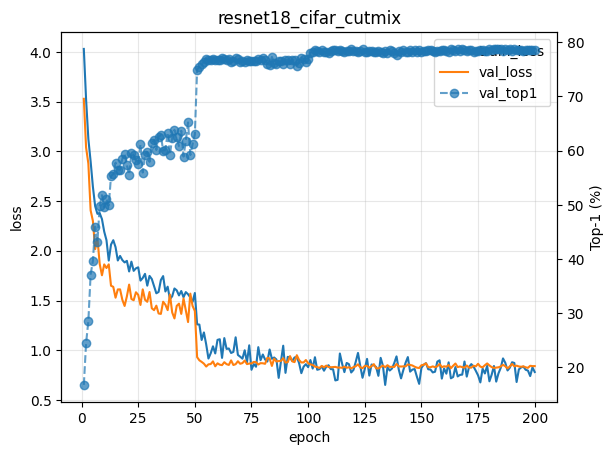


--- Test ---
loss=0.8625  top1=77.42%  top5=93.84%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": "cutmix",
    "architecture": "resnet18",
    "epochs": 200,
}

resnet18_cifar_cutmix = run_experiment("resnet18_cifar_cutmix", CONFIG)

## Cutout

100%|██████████| 169M/169M [00:13<00:00, 12.4MB/s]



--- Dataset split ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Train ---
epoch 001 train_loss=3.8776  val_loss=3.5679  top1=16.22%  top5=42.16%  lr=0.1
epoch 002 train_loss=3.2512  val_loss=3.4824  top1=18.34%  top5=46.58%  lr=0.1
epoch 003 train_loss=2.7806  val_loss=2.8312  top1=28.70%  top5=61.10%  lr=0.1
epoch 004 train_loss=2.4586  val_loss=2.9752  top1=30.32%  top5=61.26%  lr=0.1
epoch 005 train_loss=2.2452  val_loss=2.3424  top1=40.20%  top5=70.80%  lr=0.1
epoch 006 train_loss=2.0559  val_loss=2.1356  top1=43.94%  top5=75.82%  lr=0.1
epoch 007 train_loss=1.8998  val_loss=1.9837  top1=46.28%  top5=78.68%  lr=0.1
epoch 008 train_loss=1.7967  val_loss=2.1132  top1=45.58%  top5=76.62%  lr=0.1
epoch 009 train_loss=1.7040  val_loss=1.8651  top1=50.40%  top5=81.22%  lr=0.1
epoch 010 train_loss=1.6035  val_loss=1.6257  top1=54.74%  top5=84.76%  lr=0.1
epoch 011 train_loss=1.5251  val_loss=1.8915  top1=51.12%  top5=80.36%  lr=0.1
epoch 012 train_loss=1.5189  val_loss=1.8831  to

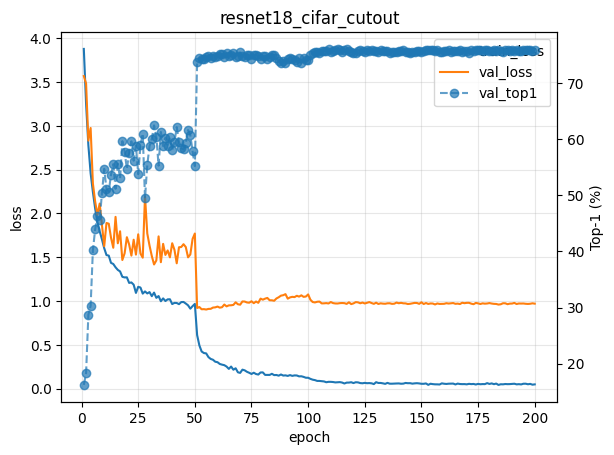


--- Test ---
loss=0.9740  top1=75.63%  top5=93.17%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": "cutout",
    "architecture": "resnet18",
    "epochs": 200,
}

resnet18_cifar_cutout = run_experiment("resnet18_cifar_cutout", CONFIG)

## MixUp


--- Dataset split ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Train ---
epoch 001 train_loss=3.9646  val_loss=3.3480  top1=19.28%  top5=46.54%  lr=0.1
epoch 002 train_loss=3.3246  val_loss=2.8324  top1=28.88%  top5=59.50%  lr=0.1
epoch 003 train_loss=2.9779  val_loss=2.5590  top1=34.10%  top5=65.86%  lr=0.1
epoch 004 train_loss=2.7520  val_loss=2.3402  top1=37.98%  top5=70.82%  lr=0.1
epoch 005 train_loss=2.5718  val_loss=2.1343  top1=43.64%  top5=74.46%  lr=0.1
epoch 006 train_loss=2.4159  val_loss=1.9589  top1=47.90%  top5=78.58%  lr=0.1
epoch 007 train_loss=2.2650  val_loss=2.1742  top1=45.28%  top5=75.06%  lr=0.1
epoch 008 train_loss=2.1430  val_loss=1.8946  top1=49.12%  top5=79.56%  lr=0.1
epoch 009 train_loss=2.3172  val_loss=1.7255  top1=54.52%  top5=83.16%  lr=0.1
epoch 010 train_loss=2.0196  val_loss=1.7559  top1=52.44%  top5=82.06%  lr=0.1
epoch 011 train_loss=2.0375  val_loss=1.6677  top1=55.98%  top5=84.62%  lr=0.1
epoch 012 train_loss=2.0072  val_loss=1.8786  to

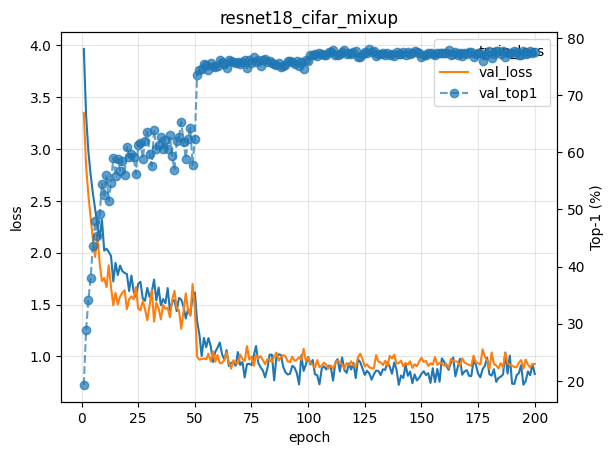


--- Test ---
loss=0.9479  top1=76.76%  top5=93.33%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": "mixup",
    "architecture": "resnet18",
    "epochs": 200,
}

resnet18_cifar_mixup = run_experiment("resnet18_cifar_mixup", CONFIG)

# ResNet-50 Tiny ImageNet

## Baseline


--- Dataset split ---
{'train': 90000, 'val': 10000, 'test': 10000}

--- Train ---
epoch 001 train_loss=5.4349  val_loss=5.2419  top1=0.79%  top5=4.64%  lr=0.1
epoch 002 train_loss=5.1511  val_loss=5.1255  top1=1.63%  top5=7.49%  lr=0.1
epoch 003 train_loss=4.9419  val_loss=4.9701  top1=2.24%  top5=10.09%  lr=0.1
epoch 004 train_loss=4.6970  val_loss=4.9939  top1=3.18%  top5=10.78%  lr=0.1
epoch 005 train_loss=4.4231  val_loss=4.9253  top1=3.47%  top5=12.21%  lr=0.1
epoch 006 train_loss=4.1692  val_loss=4.9311  top1=4.47%  top5=13.98%  lr=0.1
epoch 007 train_loss=3.9578  val_loss=4.8385  top1=4.28%  top5=15.26%  lr=0.1
epoch 008 train_loss=3.7814  val_loss=4.9182  top1=6.28%  top5=20.44%  lr=0.1
epoch 009 train_loss=3.6367  val_loss=4.5609  top1=7.38%  top5=23.06%  lr=0.1
epoch 010 train_loss=3.5047  val_loss=4.8620  top1=6.05%  top5=18.61%  lr=0.1
epoch 011 train_loss=3.3955  val_loss=4.4846  top1=8.11%  top5=23.79%  lr=0.1
epoch 012 train_loss=3.2979  val_loss=4.4964  top1=10.84%  t

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f93443dcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f93443dcea0>AssertionError
: Traceback (most recent call last):
can only test a child process  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/d

epoch 164 train_loss=0.5939  val_loss=2.7092  top1=51.06%  top5=75.73%  lr=0.0010000000000000002
epoch 165 train_loss=0.5811  val_loss=2.7001  top1=50.78%  top5=75.72%  lr=0.0010000000000000002
epoch 166 train_loss=0.5758  val_loss=2.6910  top1=51.65%  top5=76.25%  lr=0.0010000000000000002
epoch 167 train_loss=0.5672  val_loss=2.6633  top1=51.62%  top5=75.98%  lr=0.0010000000000000002
epoch 168 train_loss=0.5666  val_loss=2.6987  top1=51.37%  top5=76.30%  lr=0.0010000000000000002


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f93443dcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f93443dcea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

epoch 169 train_loss=0.5689  val_loss=2.7166  top1=51.54%  top5=76.25%  lr=0.0010000000000000002
epoch 170 train_loss=0.5585  val_loss=2.6947  top1=51.97%  top5=76.08%  lr=0.0010000000000000002
epoch 171 train_loss=0.5592  val_loss=2.6652  top1=52.30%  top5=76.31%  lr=0.0010000000000000002
epoch 172 train_loss=0.5495  val_loss=2.6787  top1=52.07%  top5=76.21%  lr=0.0010000000000000002
epoch 173 train_loss=0.5512  val_loss=2.6638  top1=52.26%  top5=76.77%  lr=0.0010000000000000002
epoch 174 train_loss=0.5417  val_loss=2.6674  top1=51.84%  top5=76.50%  lr=0.0010000000000000002
epoch 175 train_loss=0.5445  val_loss=2.6603  top1=52.05%  top5=76.05%  lr=0.0010000000000000002
epoch 176 train_loss=0.5447  val_loss=2.6946  top1=52.21%  top5=76.44%  lr=0.0010000000000000002
epoch 177 train_loss=0.5446  val_loss=2.6726  top1=51.83%  top5=76.31%  lr=0.0010000000000000002
epoch 178 train_loss=0.5393  val_loss=2.7035  top1=51.46%  top5=76.27%  lr=0.0010000000000000002
epoch 179 train_loss=0.5337  v

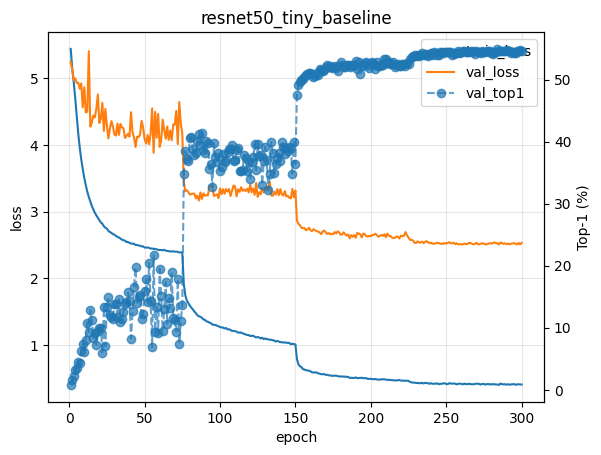


--- Test ---
loss=2.5009  top1=55.04%  top5=78.15%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "tinyimagenet",
    "aug_mode": None,
    "architecture": "resnet50",
    "epochs": 300,
}

resnet50_tiny_baseline = run_experiment("resnet50_tiny_baseline", CONFIG)

## CutMix


--- Dataset split ---
{'train': 90000, 'val': 10000, 'test': 10000}

--- Train ---
epoch 001 train_loss=5.4620  val_loss=5.2651  top1=0.90%  top5=4.29%  lr=0.1
epoch 002 train_loss=5.2162  val_loss=5.1313  top1=1.24%  top5=6.33%  lr=0.1
epoch 003 train_loss=5.1221  val_loss=5.0394  top1=2.06%  top5=8.73%  lr=0.1
epoch 004 train_loss=4.9892  val_loss=4.9646  top1=2.86%  top5=10.91%  lr=0.1
epoch 005 train_loss=4.8320  val_loss=4.9397  top1=2.80%  top5=10.35%  lr=0.1
epoch 006 train_loss=4.6656  val_loss=4.9299  top1=2.99%  top5=11.46%  lr=0.1
epoch 007 train_loss=4.4999  val_loss=4.8306  top1=4.17%  top5=14.99%  lr=0.1
epoch 008 train_loss=4.3938  val_loss=4.7832  top1=3.87%  top5=15.27%  lr=0.1
epoch 009 train_loss=4.2583  val_loss=4.8248  top1=4.96%  top5=14.82%  lr=0.1
epoch 010 train_loss=4.1247  val_loss=4.6538  top1=5.31%  top5=19.15%  lr=0.1
epoch 011 train_loss=4.0482  val_loss=4.7218  top1=5.05%  top5=16.71%  lr=0.1
epoch 012 train_loss=3.9286  val_loss=4.7223  top1=5.79%  top

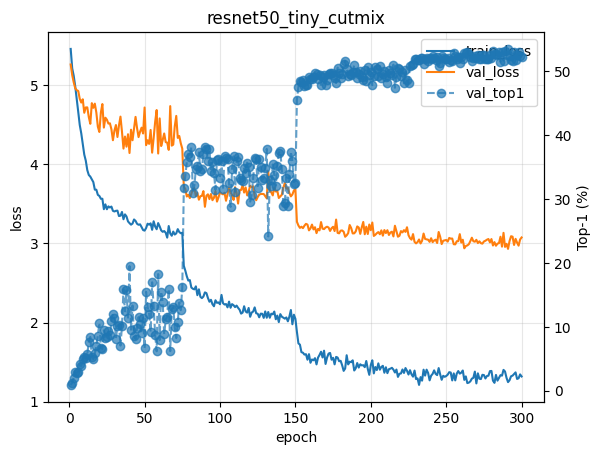


--- Test ---
loss=2.9265  top1=53.38%  top5=77.55%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "tinyimagenet",
    "aug_mode": "cutmix",
    "architecture": "resnet50",
    "epochs": 300,
}

resnet50_tiny_cutmix = run_experiment("resnet50_tiny_cutmix", CONFIG)

# Create Figures

## Training History

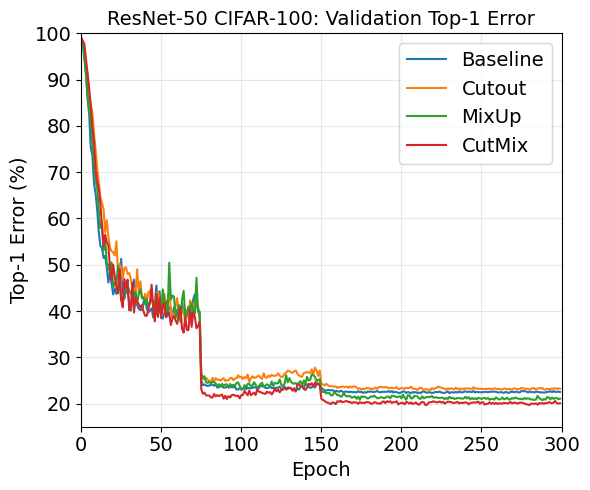

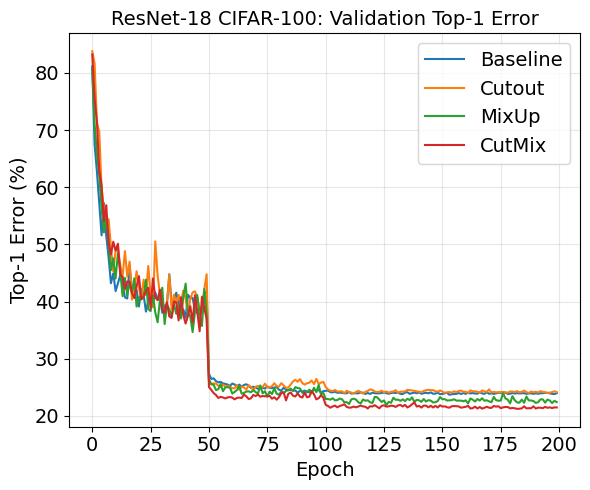

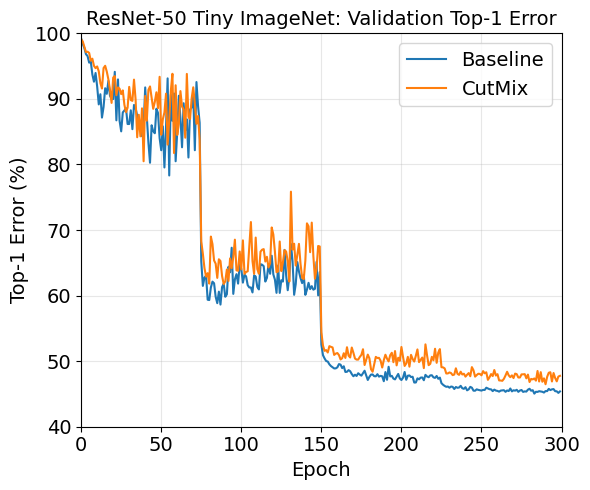

In [75]:
from pathlib import Path
from typing import Dict, List, Sequence, Tuple, Optional, Callable

import torch
import matplotlib.pyplot as plt


# -----------------------------
# Loading utilities
# -----------------------------

def load_runs(run_specs: Sequence[Tuple[str, str]], base_dir: Path) -> List[Dict]:
    """
    run_specs: list of (relative_path, label)
      relative_path is relative to base_dir (no suffix assumptions).
      label is what will appear in the legend.
    Returns a list of dicts with fields: label, history.
    """
    runs = []
    for rel_path, label in run_specs:
        ckpt_path = base_dir / rel_path
        ckpt = torch.load(ckpt_path, map_location="cpu")

        history = ckpt.get("history", ckpt)  # supports either layout
        runs.append({"label": label, "history": history})
    return runs


# -----------------------------
# Plotting utilities
# -----------------------------

def plot_metric(
    runs: Sequence[Dict],
    metric_key: str,
    *,
    title: str,
    ylabel: str,
    xlabel: str = "Epoch",
    out_dir: Path = Path("figures"),
    out_name: Optional[str] = None,
    dpi: int = 300,
    x_lim: Optional[Tuple[float, float]] = None,
    y_lim: Optional[Tuple[float, float]] = None,
    show: bool = True,
    transform: Optional[Callable[[List[float]], List[float]]] = None,
):
    """
    metric_key should be something like:
      'train_loss', 'val_loss', 'val_top1', 'val_top5', 'lr', etc.
    transform: optional function applied to the series before plotting
               (e.g., accuracy -> error).
    Saves both PNG and PDF for LaTeX.
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    out_name = out_name or metric_key

    plt.figure(figsize=(6, 5))

    for r in runs:
        series = r["history"][metric_key]
        if transform is not None:
            series = transform(series)
        plt.plot(series, label=r["label"])

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    if x_lim is not None:
        plt.xlim(*x_lim)
    if y_lim is not None:
        plt.ylim(*y_lim)
    plt.tight_layout()

    png_path = out_dir / f"{out_name}.png"
    pdf_path = out_dir / f"{out_name}.pdf"
    plt.savefig(png_path, dpi=dpi, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")  # vector, great for LaTeX

    if show:
        plt.show()
    else:
        plt.close()


acc_to_err = lambda s: [100.0 - v for v in s]


# -----------------------------
# Example usage
# -----------------------------


resnet50_cifar_specs = [
    (r"resnet50_cifar_baseline.pt", "Baseline"),
    (r"resnet50_cifar_cutout.pt",   "Cutout"),
    (r"resnet50_cifar_mixup.pt",    "MixUp"),
    (r"resnet50_cifar_cutmix.pt",   "CutMix"),
]
resnet18_cifar_specs = [
    (r"resnet18_cifar_baseline.pt", "Baseline"),
    (r"resnet18_cifar_cutout.pt",   "Cutout"),
    (r"resnet18_cifar_mixup.pt",    "MixUp"),
    (r"resnet18_cifar_cutmix.pt",   "CutMix"),
]
resnet50_tiny_specs = [
    (r"resnet50_tiny_baseline.pt", "Baseline"),
    (r"resnet50_tiny_cutmix.pt",   "CutMix"),
]

runs_50_cifar = load_runs(resnet50_cifar_specs, RESULTS_DIR)
runs_18_cifar = load_runs(resnet18_cifar_specs, RESULTS_DIR)
runs_50_tiny = load_runs(resnet50_tiny_specs, RESULTS_DIR)


plot_metric(
    runs_50_cifar, "val_top1",
    title=f"ResNet-50 CIFAR-100: Validation Top-1 Error",
    ylabel="Top-1 Error (%)",
    out_dir=Path("figures/cifar100"),
    out_name=f"ResNet-50 CIFAR-100_val_top1_err",
    x_lim=(0, 300),
    y_lim=(15, 100),
    dpi=400,
    show=True,
    transform=acc_to_err,
)

plot_metric(
    runs_18_cifar, "val_top1",
    title=f"ResNet-18 CIFAR-100: Validation Top-1 Error",
    ylabel="Top-1 Error (%)",
    out_dir=Path("figures/cifar100"),
    out_name=f"ResNet-18 CIFAR-100_val_top1_err",
    dpi=400,
    show=True,
    transform=acc_to_err,
)

plot_metric(
    runs_50_tiny, "val_top1",
    title=f"ResNet-50 Tiny ImageNet: Validation Top-1 Error",
    ylabel="Top-1 Error (%)",
    out_dir=Path("figures/tinyimagenet"),
    out_name=f"ResNet-50 Tiny ImageNet_val_top1_err",
    x_lim=(0, 300),
    y_lim=(40, 100),
    dpi=400,
    show=True,
    transform=acc_to_err,
)


## Data Augmentation Examples

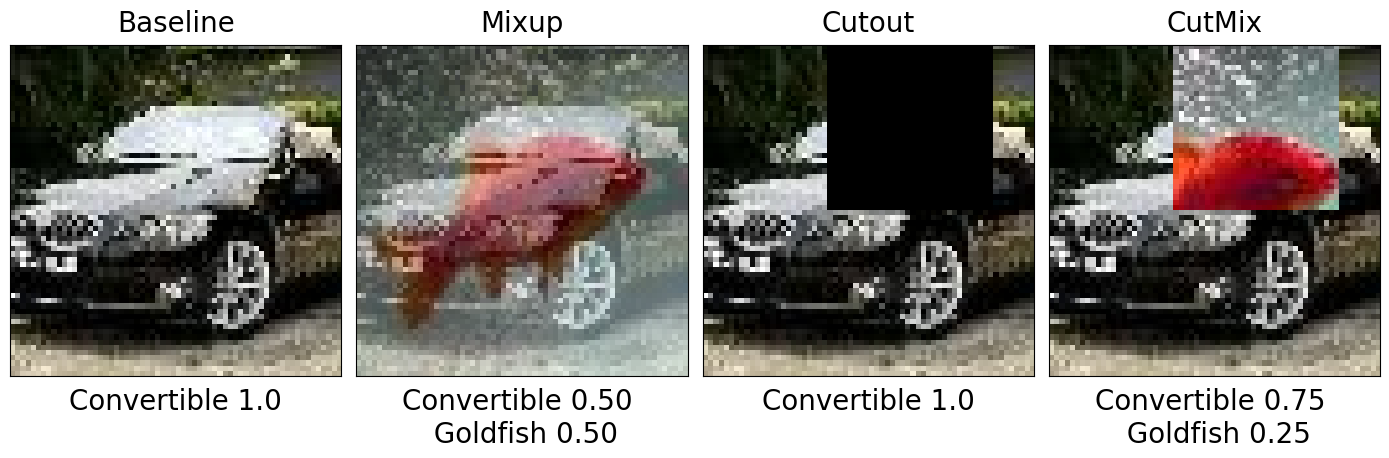

Saved to aug_row_tinyimagenet.pdf


In [54]:
# --- Colab setup ---
import math
import random
from pathlib import Path

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision.transforms.functional as TF


# -------------------------
# Utilities
# -------------------------

def load_image(path, size=None):
    """Load RGB image. Optionally resize to (H,W)."""
    img = Image.open(path).convert("RGB")
    if size is not None:
        img = img.resize((size[1], size[0]), Image.BILINEAR)  # PIL takes (W,H)
    return img

def pil_to_tensor(img):
    """PIL -> float tensor in [0,1], shape (C,H,W)."""
    return TF.to_tensor(img)

def tensor_to_pil(x):
    """float tensor (C,H,W) in [0,1] -> PIL."""
    x = x.clamp(0, 1)
    return TF.to_pil_image(x)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# -------------------------
# Augmentations (deterministic / controllable)
# -------------------------

def apply_mixup(x1, x2, lam=0.5):
    """
    x1, x2: float tensors (C,H,W) in [0,1]
    lam: mixing coefficient for primary image
    """
    return lam * x1 + (1 - lam) * x2

def apply_cutout(x, erase_frac=0.25, fill=0.0, center=None, seed=None):
    """
    x: float tensor (C,H,W)
    erase_frac: fraction of total area to erase (e.g., 0.25 = 25%)
    fill: fill value in [0,1]
    center: (cy, cx) in pixels. If None, random location.
    seed: for reproducible random location.
    """
    if seed is not None:
        set_seed(seed)

    C, H, W = x.shape
    erase_area = erase_frac * H * W
    side = int(round(math.sqrt(erase_area)))  # square patch

    if center is None:
        cy = random.randint(0, H-1)
        cx = random.randint(0, W-1)
    else:
        cy, cx = center

    y1 = max(0, cy - side // 2)
    y2 = min(H, y1 + side)
    x1 = max(0, cx - side // 2)
    x2 = min(W, x1 + side)

    out = x.clone()
    out[:, y1:y2, x1:x2] = fill
    return out

def rand_bbox(H, W, lam, seed=None):
    """Standard CutMix bbox sampling given lambda."""
    if seed is not None:
        set_seed(seed)

    cut_ratio = math.sqrt(1.0 - lam)
    cut_w = int(W * cut_ratio)
    cut_h = int(H * cut_ratio)

    cx = random.randint(0, W-1)
    cy = random.randint(0, H-1)

    x1 = np.clip(cx - cut_w // 2, 0, W)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    y2 = np.clip(cy + cut_h // 2, 0, H)

    return int(x1), int(y1), int(x2), int(y2)

def apply_cutmix(x1, x2, lam=0.5, bbox=None, seed=None):
    """
    x1 primary, x2 secondary. Pastes patch from x2 into x1.
    lam: area fraction kept from primary (approx; exact depends on bbox)
    bbox: (x1,y1,x2,y2). If None, sample from lam.
    seed: reproducible random bbox sampling.
    Returns: cutmixed tensor, effective_lambda
    """
    C, H, W = x1.shape
    if bbox is None:
        x1b, y1b, x2b, y2b = rand_bbox(H, W, lam, seed=seed)
    else:
        x1b, y1b, x2b, y2b = bbox

    out = x1.clone()
    out[:, y1b:y2b, x1b:x2b] = x2[:, y1b:y2b, x1b:x2b]

    # effective lambda based on actual area
    patch_area = (x2b - x1b) * (y2b - y1b)
    eff_lam = 1.0 - patch_area / (H * W)
    return out, eff_lam


# -------------------------
# Figure creation
# -------------------------

def make_augmentation_row(
    primary_path,
    secondary_path,
    *,
    primary_label="Primary",
    secondary_label="Secondary",
    out_path="augmentation_row.png",
    size=(64, 64),  # (H,W); set None to keep original
    mixup_lam=0.5,
    cutout_frac=0.25,
    cutout_fill=0.0,
    cutout_center=None,  # e.g., (H//2, W//2)
    cutmix_lam=0.5,
    cutmix_bbox=None,    # e.g., (x1,y1,x2,y2)
    seed=0,
    dpi=400,
):
    """
    Produces 1x4 row: Baseline | MixUp | Cutout | CutMix.
    Labels technique above, class/mix label below.
    """
    set_seed(seed)

    # Load + match sizes
    img1 = load_image(primary_path, size=size)
    img2 = load_image(secondary_path, size=size)

    x1 = pil_to_tensor(img1)
    x2 = pil_to_tensor(img2)

    # Baseline
    baseline_img = tensor_to_pil(x1)
    baseline_text = primary_label + " 1.0"

    # MixUp
    mixup_x = apply_mixup(x1, x2, lam=mixup_lam)
    mixup_img = tensor_to_pil(mixup_x)
    mixup_text = f"{primary_label} {mixup_lam:.2f} \n {secondary_label} {1-mixup_lam:.2f}"

    # Cutout
    cutout_x = apply_cutout(
        x1, erase_frac=cutout_frac, fill=cutout_fill,
        center=cutout_center, seed=seed
    )
    cutout_img = tensor_to_pil(cutout_x)
    cutout_text = primary_label + " 1.0"

    # CutMix
    cutmix_x, eff_lam = apply_cutmix(
        x1, x2, lam=cutmix_lam,
        bbox=cutmix_bbox, seed=seed
    )
    cutmix_img = tensor_to_pil(cutmix_x)
    cutmix_text = f"{primary_label} {eff_lam:.2f} \n {secondary_label} {1-eff_lam:.2f}"

    panels = [
        ("Baseline", baseline_img, baseline_text),
        ("Mixup",    mixup_img,    mixup_text),
        ("Cutout",   cutout_img,   cutout_text),
        ("CutMix",   cutmix_img,   cutmix_text),
    ]

    fig, axes = plt.subplots(1, 4, figsize=(14, 4))
    for ax, (title, im, lbl) in zip(axes, panels):
        ax.imshow(im)
        ax.set_title(title, fontsize=20, pad=10)   # technique ABOVE
        ax.set_xlabel(lbl, fontsize=20, labelpad=8)  # label BELOW
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"Saved to {out_path}")


# -------------------------
# Example usage (edit these)
# -------------------------

ensure_tinyimagenet()
# Put your two image paths here. In Colab you can upload, then use /content/filename.jpg
primary_path = "/content/data/tiny-imagenet-200/train/n03100240/images/n03100240_103.JPEG"
secondary_path = "/content/data/tiny-imagenet-200/train/n01443537/images/n01443537_10.JPEG"

make_augmentation_row(
    primary_path,
    secondary_path,
    primary_label="Convertible",
    secondary_label="Goldfish",
    size=(64, 64),          # match Tiny ImageNet; use (32,32) for CIFAR
    mixup_lam=0.5,
    cutout_frac=0.25,
    cutout_fill=0.0,
    cutout_center=(16, 40),     # or (32,32) for deterministic center
    cutmix_lam=0.75,
    cutmix_bbox=(24, 0, 56, 32),       # or set fixed box like (10,10,40,40)
    seed=3,
    out_path="aug_row_tinyimagenet.pdf",
    dpi=500,
)
